# LOS Prediction - LSTM for Time-Based Data

This notebook performs LOS prediction on data from the first X days from each patient. The goal is to utilize more of the dataset in order to see how the performance changes with respect to a standard DNN that only uses data from the first 24 or 48 hours.

In [0]:
###
#
# Imports Block
#
###

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU
from google.colab import drive
import numpy as np

print(tf.__version__)

drive.mount('/content/drive')

Using TensorFlow backend.


1.15.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
###
#
# Data Import and Conversion to 3D Array
#
###
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from math import sqrt

# Consider imputing the data with values other than zero
raw_dataset = pd.read_csv('/content/drive/My Drive/Stanford/CS221/timestep.filtered.csv', header=0, index_col=0)
df = raw_dataset.copy()

# One hot encode the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    df = df.join(one_hot)

df = df.loc[:, (df==0).mean() < .9]
df = df[df['los'] <= 100]

los = df.pop('los').values


# df.pop('status') # Not in use for this analysis
timesteps = df.pop('timestep') # Temporarily removed so we don't scale this

#
# Manual feature selection 
#
# print("Num rows in data: " + str(len(df)))
# print("Num columns before feature selection: " + str(len(df.columns)))
# df = df.filter(['Systolic', 'Diastolic', 'age', 'Anion Gap', 'Platelet Count', 'Heart Rate', 'O2-trend', 'Bicarbonate-trend', 'Phosphate', 'MCV-trend', 'White Blood Cells-trend', 'Neutrophils', 'Lactate', 'White Blood Cells', 'RDW', 'Lactate Dehydrogenase (LD)'])
# print("Num columns after feature selection: " + str(len(df.columns)))

#
# Normalize the dataset
#
train_stats = df.describe()
train_stats = train_stats.transpose()
scaled_features = StandardScaler().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# #
# # Feature selection based on f_regression
# #
# from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
# from statsmodels.stats.multitest import multipletests
# print("Num rows in data: " + str(len(df)))
# print("Num columns before feature selection: " + str(len(df.columns)))
# sfm = SelectKBest(f_regression, k=64)
# sfm.fit(df, los)
# feature_idx = sfm.get_support()
# df = df.loc[:,feature_idx]
# print("Num columns after feature selection: " + str(len(df.columns)))
# print(df.columns)


# RUN FEATURE SELECTION BASED ON ELASTIC NET LINEAR REGRESSION
elastic = ElasticNet(l1_ratio=0.35, max_iter=10000)
elastic.fit(df, los)
coef = pd.Series(elastic.coef_, index = df.columns)
# features = coef.abs().sort_values(ascending=False).head(64).index
features = df.columns[coef != 0]
df = df[list(features)]
print(features)
print("Num columns after feature selection: " + str(len(df.columns)))


df.insert(0, "timestep", timesteps, True)
print(len(df.values))



Index(['age', 'Hematocrit', 'Hemoglobin', 'Lymphocytes', 'Monocytes',
       'Platelet Count', 'Red Blood Cells', 'Urea Nitrogen', 'pCO2', 'pH',
       'pO2', 'Phosphate', 'Oxygen Saturation', 'PEEP', 'Albumin',
       'Alkaline Phosphatase', 'Lactate Dehydrogenase (LD)',
       'Potassium, Whole Blood', 'Free Calcium', 'NS250', 'IPRAPF', 'VIAL',
       'ALBU3H', 'NS/MBP100I', 'NS1000', 'ONDAN4I', 'HEPA10SYR', 'SENN187',
       'KCL20PM', 'D5W100', 'NYST5L', 'METO50', 'METO25', 'HEPA5I', 'NS100',
       'MAG2PM', 'CALG1I', 'LORA2I', 'IPRA2H', 'NACLFLUSH', 'BISA10R',
       'D5W250', 'OXYC5', 'KCLBASE2', 'ASA325', 'Systolic', 'O2 Flow.1', 'O2',
       'insurance_Medicaid', 'insurance_Medicare', 'language_0',
       'language_ENGL', 'marital_status_SINGLE'],
      dtype='object')
Num columns after feature selection: 53
50871


In [35]:

window_size = 5
max_sequence_length = 10
num_features = len(df.values[0]) - 1 # -1 accounts for the timestep column we are removing

lstm_input = []
lstm_los = []


##### CREATE A SQUARE MATRIX REPRESENTING PATIENT SEQUENCES WITH ONE OUTPUT #####
# 0,       0, x[0, 1], x[0, 2] -> y[0]
# 0, x[1, 1], x[1, 2], x[1, 3] -> y[1]
# This strategy uses stateless LSTM. We could use stateful LSTM and manually update at each timepoint in each patient 
# sequence, but this is extremely slow (note state is manually reset only after each patient sequence is finished). 
# https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM

# Data frame is assumed to be sorted in order of timesteps for each patient
vals = df.values
i = 0
while i < len(vals):
    row = vals[i]
    timestep = row[0]
    remaining_los = los[i]
    patient_sequence = []
    start_i = i
    i += 1
    # Skip until the next patient sequence
    while i < len(vals) and vals[i][0] != 0:
        i += 1
    end_i = i
    
    if end_i - start_i < window_size:
        # Consider removing these patient samples
        # Note: We need to front-pad the sequence with zeros in order to make sure we have a rectangular input
        for _ in range(window_size - (end_i - start_i)):
            patient_sequence.insert(0, [0] * num_features)
        r = start_i
        while r < end_i:
            patient_sequence.append(vals[r, 1:])
            r += 1

        #######################################################
        # COMMENT BELOW IF WE DON'T WANT TO KEEP SHORT SEQUENCES
        #######################################################
        #lstm_input.append(patient_sequence)
        #lstm_los.append(remaining_los - window_size)
    else:
        # Create our sliding window data
        for offset in range(min(max_sequence_length, (end_i - start_i) - window_size + 1)):
            patient_sequence = []
            r = start_i + offset
            while r < start_i + offset + window_size:
                patient_sequence.append(vals[r, 1:])
                r += 1
            lstm_input.append(patient_sequence)
            lstm_los.append(remaining_los - offset - window_size)

            #######################################################
            # COMMENT BELOW IF WE WANT TO USE SLIDING WINDOW
            #######################################################
            break
        
lstm_input = np.array(lstm_input)
lstm_los = np.array(lstm_los)
lstm_los_cat = [[1 if a[0] else 0, 1 if a[1] else 0] for a in zip(lstm_los <= 10.75, lstm_los > 10.75)]
lstm_los_cat = np.array(lstm_los_cat)

indices = np.random.permutation(lstm_input.shape[0])
print(indices)
div_point = int(len(lstm_input) * 0.7)
training_idx, test_idx = indices[:div_point], indices[div_point:]
train_dataset, test_dataset = lstm_input[training_idx,:], lstm_input[test_idx,:]
train_labels, test_labels = lstm_los[training_idx], lstm_los[test_idx]

#######################################################
# UNCOMMENT BELOW IF WE WANT TO LIMIT NUM OF SAMPLES
#######################################################
# lstm_input = lstm_input[:2000, :]
# lstm_los = lstm_los[:2000]

print("Number of samples = " + str(len(lstm_los)))
#lstm_input[1]
# lstm_input[0][0]
# lstm_los[4]
print(lstm_los_cat)

[ 985 3182  445 ...  954 1021 2572]
Number of samples = 3437
[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [36]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# num hidden = (2408) / (alpha * (64 + 1)) = 26 (@ alpha = 2)

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
def build_model():
  # Notes:
  # - Use batch_input_shape=(batch_size, # timesteps, # features) param if using Stateful 
  #   (we're dynamically controlling the state at that point - ie. we can have varying sequence lengths)
    
  model = Sequential([
    # Trial 1
    # val = 6.174688288051363
    # LSTM(32, input_shape=(window_size, num_features), return_sequences=True, dropout=0.5, stateful=False),
    # LSTM(32, input_shape=(window_size, num_features), return_sequences=True, dropout=0.5, stateful=False),
    # LSTM(32, input_shape=(window_size, num_features), dropout=0.5, stateful=False), 
    
    
    #layers.LSTM(32, input_shape=(window_size, num_features), return_sequences=True, stateful=False, dropout=0.3, recurrent_dropout=0.3, recurrent_regularizer=regularizers.l1_l2(0.01, 0.01)),
    LSTM(12, input_shape=(window_size, num_features), return_sequences=True, dropout=0.5, stateful=False),
    # LSTM(26, input_shape=(window_size, num_features), return_sequences=True, dropout=0.5, stateful=False),
    LSTM(12, input_shape=(window_size, num_features), dropout=0.5, stateful=False),
    # layers.Dropout(0.5, name='dropout_2'),
    #layers.Dense(64, activation='relu', input_shape=[num_features]),
    #layers.Dropout(0.5, name='dropout_2'),
    #layers.Dense(32, activation='relu', input_shape=[num_features]),
    Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_cnn():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size,num_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
  return model

def build_cnn_cat():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size,num_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = build_model()
# model = build_cnn_cat()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 5, 12)             3168      
_________________________________________________________________
lstm_12 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 4,381
Trainable params: 4,381
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# # Batch size defaults to 32
history = model.fit(
  lstm_input, lstm_los,
  batch_size=1,
  epochs=EPOCHS, validation_split = 0.3, verbose=1,
  callbacks=[PrintDot()])

#### CAT ####
# Batch size defaults to 32
# history = model.fit(
#   train_dataset, train_labels,
#   batch_size=1,
#   epochs=EPOCHS, validation_split = 0.3, verbose=1)


Train on 2405 samples, validate on 1032 samples
Epoch 1/50
2405/2405 [==============================] - 26s 11ms/step - loss: 120.7879 - mean_absolute_error: 7.1544 - mean_squared_error: 120.7879 - val_loss: 117.4261 - val_mean_absolute_error: 7.2520 - val_mean_squared_error: 117.4261

.Epoch 2/50
2405/2405 [==============================] - 23s 10ms/step - loss: 104.4475 - mean_absolute_error: 6.8567 - mean_squared_error: 104.4475 - val_loss: 110.4172 - val_mean_absolute_error: 6.8731 - val_mean_squared_error: 110.4172
.Epoch 3/50
2405/2405 [==============================] - 23s 10ms/step - loss: 100.7119 - mean_absolute_error: 6.7468 - mean_squared_error: 100.7119 - val_loss: 107.4389 - val_mean_absolute_error: 6.5618 - val_mean_squared_error: 107.4389
.Epoch 4/50
2405/2405 [==============================] - 23s 10ms/step - loss: 98.8074 - mean_absolute_error: 6.7029 - mean_squared_error: 98.8074 - val_loss: 105.0291 - val_mean_absolute_error: 6.4069 - val_mean_squared_error: 105.029

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
print("MAE = " + str(hist["mean_absolute_error"][10:].mean()))
print("Val MAE = " + str(hist["val_mean_absolute_error"][10:].mean()))

MAE = 6.1586352591009
Val MAE = 6.1416304880912005


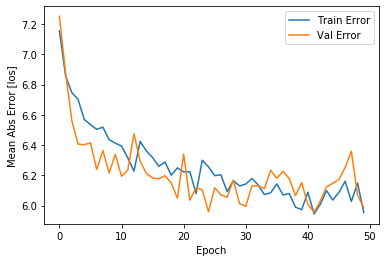

Testing (LOS): 5.508011575033499


In [39]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,max(hist['val_mean_absolute_error'])])
  plt.legend()

  plt.show()


plot_history(history)

actual_predictions = model.predict(test_dataset)
test_error = mean_absolute_error(test_labels, actual_predictions)
print("Testing (LOS): " + str(test_error))
